# Resource competition: light and Fe in the Southern Ocean

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob

import xarray as xr
import numpy as np

import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats
import matplotlib.path as mpath
import math

### get pop grid

In [2]:
grid = pop_tools.get_grid('POP_gx1v6')

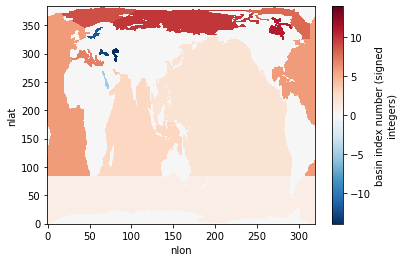

In [3]:
grid.REGION_MASK.plot()

In [4]:
grid

<xarray.Dataset>
Dimensions:      (nlat: 384, nlon: 320, nreg: 14, z_t: 60, z_w: 60, z_w_bot: 60)
Coordinates:
  * z_t          (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_w          (z_w) float64 0.0 1e+03 2e+03 3e+03 ... 4.75e+05 5e+05 5.25e+05
  * z_w_bot      (z_w_bot) float64 1e+03 2e+03 3e+03 ... 5e+05 5.25e+05 5.5e+05
  * nreg         (nreg) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13
Dimensions without coordinates: nlat, nlon
Data variables:
    TLAT         (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG        (nlat, nlon) float64 320.6 321.7 322.8 ... 318.9 319.4 319.8
    ULAT         (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.42 72.41 72.41
    ULONG        (nlat, nlon) float64 321.1 322.3 323.4 ... 319.2 319.6 320.0
    DXT          (nlat, nlon) float64 1.894e+06 1.893e+06 ... 1.473e+06
    DYT          (nlat, nlon) float64 5.94e+06 5.94e+06 ... 5.046e+06 5.046e+06
    DXU          (nlat, nlon) float64 2.397e+06 2.397e+06 ... 1.391e+06
    DYU          (nlat, nlon) float64 5.94e+06 5.94e+06 ... 5.493e+06 5.493e+06
    TAREA        (nlat, nlon) float64 1.125e+13 1.125e+13 ... 7.432e+12
    UAREA        (nlat, nlon) float64 1.423e+13 1.423e+13 ... 7.639e+12
    KMT          (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    REGION_MASK  (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    dz           (z_t) float64 1e+03 1e+03 1e+03 ... 2.499e+04 2.5e+04 2.5e+04
    region_name  (nreg) <U21 'Caspian Sea' 'Black Sea' ... 'Hudson Bay'
    region_val   (nreg) int64 -14 -13 -12 -5 1 2 3 4 6 7 8 9 10 11
Attributes:
    lateral_dims:       [384, 320]
    vertical_dims:      60
    vert_grid_file:     gx1v7_vert_grid
    horiz_grid_fname:   inputdata/ocn/pop/gx1v6/grid/horiz_grid_20010402.ieeer8
    topography_fname:   inputdata/ocn/pop/gx1v6/grid/topography_20090204.ieeei4
    region_mask_fname:  inputdata/ocn/pop/gx1v6/grid/region_mask_20090205.ieeei4
    type:               dipole
    title:              POP_gx1v6 grid

### Get the CESM-LE variables (seasonal means calculated in cesm-le-seasonal_means.ipynb)

### DJF

In [5]:
%%time
path = '/glade/scratch/kristenk/CESM-LE-output/CESM-LE-'
variables = ['Fe_avg_50m','PAR_avg_50m','diatC_50m_zint','spC_50m_zint','TEMP_50m_mean']

ds_list = []
ds_DJF = xr.Dataset()

for v in variables:  
    print(v)
    files = sorted(glob(f'{path}{v}_DJFmean.nc'))  

    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    ds_DJF = xr.merge((ds_DJF, dsv))
    ds_list.append(ds_DJF)
    
ds_DJF['phytoC_50m_zint'] = ds_DJF.diatC_50m_zint + ds_DJF.spC_50m_zint
ds_DJF = ds_DJF.where(grid.REGION_MASK>0)

Fe_avg_50m
PAR_avg_50m
diatC_50m_zint
spC_50m_zint
TEMP_50m_mean
CPU times: user 345 ms, sys: 25.9 ms, total: 371 ms
Wall time: 738 ms


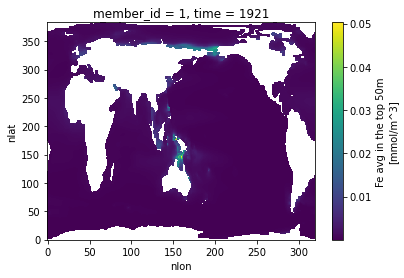

In [6]:
ds_DJF.Fe_avg_50m.sel(time=1921,member_id=1).plot()

In [7]:
ds_DJF

<xarray.Dataset>
Dimensions:          (member_id: 34, nlat: 384, nlon: 320, time: 180, z_t: 60)
Coordinates:
    TLAT             (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG            (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * member_id        (member_id) int64 1 2 9 10 11 12 ... 35 101 102 103 104 105
  * time             (time) int64 1921 1922 1923 1924 ... 2097 2098 2099 2100
Dimensions without coordinates: nlat, nlon, z_t
Data variables:
    KMT              (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TAREA            (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    dz               (z_t, nlat, nlon) float32 dask.array<chunksize=(60, 384, 320), meta=np.ndarray>
    Fe_avg_50m       (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 34, 384, 320), meta=np.ndarray>
    PAR_avg_50m      (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 34, 384, 320), meta=np.ndarray>
    diatC_50m_zint   (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 34, 384, 320), meta=np.ndarray>
    spC_50m_zint     (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 34, 384, 320), meta=np.ndarray>
    TEMP_50m_mean    (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 34, 384, 320), meta=np.ndarray>
    phytoC_50m_zint  (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 34, 384, 320), meta=np.ndarray>

### MAM

In [8]:
%%time
path = '/glade/scratch/kristenk/CESM-LE-output/CESM-LE-'
variables = ['Fe_avg_50m','PAR_avg_50m','diatC_50m_zint','spC_50m_zint','TEMP_50m_mean']

ds_list = []
ds_MAM = xr.Dataset()

for v in variables:  
    print(v)
    files = sorted(glob(f'{path}{v}_MAMmean.nc'))  

    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    ds_MAM = xr.merge((ds_MAM, dsv))
    ds_list.append(ds_MAM)
    
ds_MAM['phytoC_50m_zint'] = ds_MAM.diatC_50m_zint + ds_MAM.spC_50m_zint
ds_MAM = ds_MAM.where(grid.REGION_MASK>0)

Fe_avg_50m
PAR_avg_50m
diatC_50m_zint
spC_50m_zint
TEMP_50m_mean
CPU times: user 358 ms, sys: 22.6 ms, total: 381 ms
Wall time: 886 ms


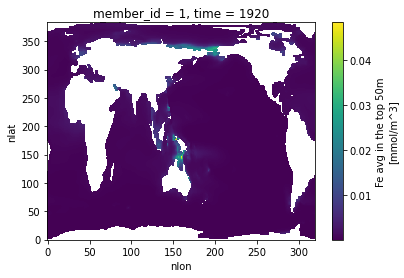

In [9]:
ds_MAM.Fe_avg_50m.isel(time=0,member_id=0).plot()

### JJA

In [10]:
%%time
path = '/glade/scratch/kristenk/CESM-LE-output/CESM-LE-'
variables = ['Fe_avg_50m','PAR_avg_50m','diatC_50m_zint','spC_50m_zint','TEMP_50m_mean']

ds_list = []
ds_JJA = xr.Dataset()

for v in variables:  
    print(v)
    files = sorted(glob(f'{path}{v}_JJAmean.nc'))  

    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    ds_JJA = xr.merge((ds_JJA, dsv))
    ds_list.append(ds_JJA)
    
ds_JJA['phytoC_50m_zint'] = ds_JJA.diatC_50m_zint + ds_JJA.spC_50m_zint
ds_JJA = ds_JJA.where(grid.REGION_MASK>0)

Fe_avg_50m
PAR_avg_50m
diatC_50m_zint
spC_50m_zint
TEMP_50m_mean
CPU times: user 345 ms, sys: 17.1 ms, total: 362 ms
Wall time: 840 ms


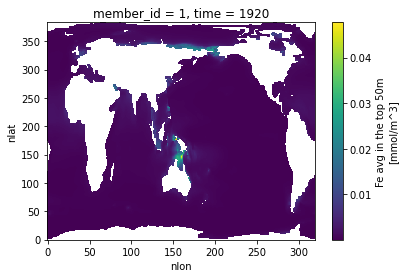

In [11]:
ds_JJA.Fe_avg_50m.isel(time=0,member_id=0).plot()

### SON

In [12]:
%%time
path = '/glade/scratch/kristenk/CESM-LE-output/CESM-LE-'
variables = ['Fe_avg_50m','PAR_avg_50m','diatC_50m_zint','spC_50m_zint','TEMP_50m_mean']

ds_list = []
ds_SON = xr.Dataset()

for v in variables:  
    print(v)
    files = sorted(glob(f'{path}{v}_SONmean.nc'))  

    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    ds_SON = xr.merge((ds_SON, dsv))
    ds_list.append(ds_SON)
    
ds_SON['phytoC_50m_zint'] = ds_SON.diatC_50m_zint + ds_SON.spC_50m_zint
ds_SON = ds_SON.where(grid.REGION_MASK>0)

Fe_avg_50m
PAR_avg_50m
diatC_50m_zint
spC_50m_zint
TEMP_50m_mean
CPU times: user 344 ms, sys: 20.3 ms, total: 365 ms
Wall time: 776 ms


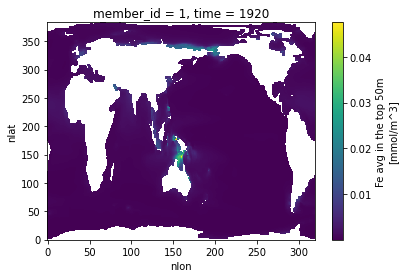

In [13]:
ds_SON.Fe_avg_50m.isel(time=0,member_id=0).plot()

### concat seasonal datasets

In [14]:
ds = xr.concat((ds_DJF, ds_MAM, ds_JJA, ds_SON),'season')

In [15]:
ds.Fe_avg_50m

<xarray.DataArray 'Fe_avg_50m' (season: 4, time: 181, member_id: 34, nlat: 384, nlon: 320)>
dask.array<concatenate, shape=(4, 181, 34, 384, 320), dtype=float64, chunksize=(1, 181, 34, 384, 320), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) int64 1920 1921 1922 1923 1924 ... 2097 2098 2099 2100
    TLAT       (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG      (nlat, nlon) float64 320.6 321.7 322.8 ... 318.9 319.4 319.8
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
Dimensions without coordinates: season, nlat, nlon
Attributes:
    long_name:     Fe avg in the top 50m
    units:         mmol/m^3
    grid_loc:      3111
    cell_methods:  time: mean

In [16]:
ds['season'] = ['DJF','MAM','JJA','SON'] 

In [17]:
ds

<xarray.Dataset>
Dimensions:          (member_id: 34, nlat: 384, nlon: 320, season: 4, time: 181, z_t: 60)
Coordinates:
  * time             (time) int64 1920 1921 1922 1923 ... 2097 2098 2099 2100
    TLAT             (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.19 72.19
    TLONG            (nlat, nlon) float64 320.6 321.7 322.8 ... 319.4 319.8
  * member_id        (member_id) int64 1 2 9 10 11 12 ... 35 101 102 103 104 105
  * season           (season) <U3 'DJF' 'MAM' 'JJA' 'SON'
Dimensions without coordinates: nlat, nlon, z_t
Data variables:
    KMT              (season, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    TAREA            (season, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    dz               (season, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 60, 384, 320), meta=np.ndarray>
    Fe_avg_50m       (season, time, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 181, 34, 384, 320), meta=np.ndarray>
    PAR_avg_50m      (season, time, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 181, 34, 384, 320), meta=np.ndarray>
    diatC_50m_zint   (season, time, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 181, 34, 384, 320), meta=np.ndarray>
    spC_50m_zint     (season, time, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 181, 34, 384, 320), meta=np.ndarray>
    TEMP_50m_mean    (season, time, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 181, 34, 384, 320), meta=np.ndarray>
    phytoC_50m_zint  (season, time, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 181, 34, 384, 320), meta=np.ndarray>

#### augment list of variables

In [18]:
variables = variables + ['phytoC_50m_zint']

### Necessary plotting function

In [19]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

In [20]:
lons = grid.TLONG
lats = grid.TLAT
area = grid.TAREA
years = ds.time.values
years

array([1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930,
       1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941,
       1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952,
       1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963,
       1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974,
       1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985,
       1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996,
       1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029,
       2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040,
       2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051,
       2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062,
       2063, 2064, 2065, 2066, 2067, 2068, 2069, 20

### extract 1920s

In [21]:
ds.time.isel(time=slice(0,10)).values

array([1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929])

In [22]:
ds_1920s = ds.isel(time=slice(0,10)).mean(dim='time')

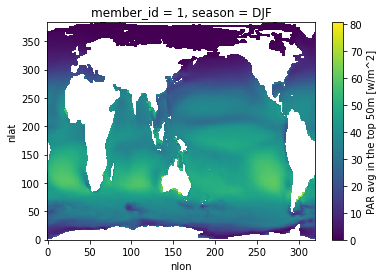

In [23]:
ds_1920s.PAR_avg_50m.isel(member_id=0,season=0).plot()

### extract 1990s

In [24]:
ds.time.isel(time=slice(70,80)).values

array([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999])

In [25]:
ds_1990s = ds.isel(time=slice(70,80)).mean(dim='time')

### Extract 2090s

In [26]:
ds.time.isel(time=slice(-11,-1)).values

array([2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099])

In [27]:
ds_2090s = ds.isel(time=slice(-11,-1)).mean(dim='time')

### make ensemble mean

In [28]:
ensemble_mean_1920s = ds_1920s.mean(dim='member_id')
ensemble_mean_1990s = ds_1990s.mean(dim='member_id')
ensemble_mean_2090s = ds_2090s.mean(dim='member_id')

### get masks for making averages

In [29]:
file = '/glade/work/kristenk/TTE_CESM-LE/masks_1990s_v3.nc'
ds_masks = xr.open_dataset(file,decode_times=False)
ds_masks

<xarray.Dataset>
Dimensions:            (nlat: 384, nlon: 320)
Coordinates:
    TLAT               (nlat, nlon) float64 ...
    TLONG              (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon
Data variables:
    ACC_mask           (nlat, nlon) float64 ...
    SIZ_mask           (nlat, nlon) float64 ...
    marginal_SIZ_mask  (nlat, nlon) float64 ...

### get the upper 50m average of PAR, Fe, phytoC

#### ACC

In [30]:
ACC_values_ds_1920s = xr.Dataset({v: ensemble_mean_1920s[v] for v in ['season']})
ACC_values_ds_1990s = xr.Dataset({v: ensemble_mean_1990s[v] for v in ['season']})
ACC_values_ds_2090s = xr.Dataset({v: ensemble_mean_2090s[v] for v in ['season']})


for var in variables:
    masked = ensemble_mean_1920s[var].where(ds_masks.ACC_mask==1.)
    ACC_values_ds_1920s[var] = esmlab.weighted_mean(masked, weights=area, dim=['nlat', 'nlon']).compute()
    
    masked = ensemble_mean_1990s[var].where(ds_masks.ACC_mask==1.)
    ACC_values_ds_1990s[var] = esmlab.weighted_mean(masked, weights=area, dim=['nlat', 'nlon']).compute()
    
    masked = ensemble_mean_2090s[var].where(ds_masks.ACC_mask==1.)
    ACC_values_ds_2090s[var] = esmlab.weighted_mean(masked, weights=area, dim=['nlat', 'nlon']).compute()

#### SIZ

In [31]:
SIZ_values_ds_1920s = xr.Dataset({v: ensemble_mean_1920s[v] for v in ['season']})
SIZ_values_ds_1990s = xr.Dataset({v: ensemble_mean_1990s[v] for v in ['season']})
SIZ_values_ds_2090s = xr.Dataset({v: ensemble_mean_2090s[v] for v in ['season']})


for var in variables:
    masked = ensemble_mean_1920s[var].where(ds_masks.SIZ_mask==1.)
    SIZ_values_ds_1920s[var] = esmlab.weighted_mean(masked, weights=area, dim=['nlat', 'nlon']).compute()
    
    masked = ensemble_mean_1990s[var].where(ds_masks.SIZ_mask==1.)
    SIZ_values_ds_1990s[var] = esmlab.weighted_mean(masked, weights=area, dim=['nlat', 'nlon']).compute()
    
    masked = ensemble_mean_2090s[var].where(ds_masks.SIZ_mask==1.)
    SIZ_values_ds_2090s[var] = esmlab.weighted_mean(masked, weights=area, dim=['nlat', 'nlon']).compute()

### check range of Temp, PAR and Fe values to make sure these are included in the resource competition plot

In [33]:
ACC_values_ds_1920s.Fe_avg_50m.values

array([0.00013433, 0.0001173 , 0.00018526, 0.0002182 ])

In [34]:
ACC_values_ds_2090s.Fe_avg_50m.values

array([0.00014711, 0.00012751, 0.00020102, 0.00023522])

In [37]:
ACC_values_ds_1920s.PAR_avg_50m.mean(dim='season').values

array(17.6496402)

In [38]:
ACC_values_ds_2090s.PAR_avg_50m.mean(dim='season').values

array(16.94017581)

In [36]:
ACC_values_ds_1920s.TEMP_50m_mean.values#.mean(dim='season').values

array([4.67823612, 4.67969612, 2.10878743, 1.71585185])

In [41]:
ACC_values_ds_2090s.TEMP_50m_mean.values

array([7.77750076, 7.86898907, 5.29850921, 4.8470217 ])

In [37]:
SIZ_values_ds_1920s.Fe_avg_50m.values

array([0.00014423, 0.00014033, 0.000238  , 0.0003027 ])

In [38]:
SIZ_values_ds_2090s.Fe_avg_50m.values

array([0.00011621, 0.00012481, 0.00021995, 0.00027421])

In [39]:
SIZ_values_ds_1920s.PAR_avg_50m.mean(dim='season').values

array(5.61785302)

In [41]:
SIZ_values_ds_2090s.PAR_avg_50m.mean(dim='season').values

array(8.63137695)

In [42]:
SIZ_values_ds_1920s.TEMP_50m_mean.values

array([-1.15374345, -1.37839866, -1.7908158 , -1.76622116])

In [43]:
SIZ_values_ds_2090s.TEMP_50m_mean.values

array([ 0.43254173,  0.48102457, -1.47118895, -1.63308911])

### Look how biomass varies to see how to vary the size of the points

In [39]:
ACC_values_ds_1920s.phytoC_50m_zint.values

array([164.8059897 ,  56.89490336,  25.32570933,  86.05891114])

In [44]:
ACC_values_ds_2090s.phytoC_50m_zint.values

array([151.26828039,  51.69089056,  25.03937673,  74.42378842])

In [45]:
SIZ_values_ds_1920s.phytoC_50m_zint.values

array([246.38469262,  36.33568903,   3.71588565,  34.77271566])

In [46]:
SIZ_values_ds_2090s.phytoC_50m_zint.values

array([232.17859623,  44.72712037,   6.15919659,  75.31907156])

### set vars to annual mean PAR.  for. zones/epochs

In [42]:
PAR_2090s_SIZ = SIZ_values_ds_2090s.PAR_avg_50m.mean(dim='season').values

In [43]:
PAR_1920s_SIZ = SIZ_values_ds_1920s.PAR_avg_50m.mean(dim='season').values

In [44]:
PAR_2090s_ACC = ACC_values_ds_2090s.PAR_avg_50m.mean(dim='season').values

In [45]:
PAR_1920s_ACC = ACC_values_ds_1920s.PAR_avg_50m.mean(dim='season').values

## start work on resource competition, parameter values are from CESM1

#### cycle through values and calculate growth rate for sp and diat, taking difference

## at PAR = 5 W/m2

In [49]:
### Specify parameters
Tref = 30.
q10 = 2.0

alpha_pi_diat = 0.3
alpha_pi_sp = 0.34

thetaN_max_diat = 4
thetaN_max_sp = 2.5

NtoC = 0.137

thetaC_diat = thetaN_max_diat * NtoC
thetaC_sp = thetaN_max_sp * NtoC

PCref_diat = 4.8
PCref_sp = 4.8

kFe_diat = 8.e-5
kFe_sp = 3.e-5

## PAR and Fe ranges and temperature
Fe_vals = np.arange(0.000004,0.00040,0.000004)
Temp_vals = np.arange(0,8,0.08)

PAR = 5



## initialize empty matrices
sp_growthrate_5PAR = np.full((100,100),np.nan)
diat_growthrate_5PAR = np.full((100,100),np.nan)

i=0
j=0

for Fe in Fe_vals: # i loop
    
    for T in Temp_vals: # j loop
        
        #calculate tfunc
        Tfunc = q10**((T - Tref) / 10.)
        
        ### temperature adjusted max growth rate
        max_gr = PCref_sp * Tfunc 
        
        ##### small phytoplankton
        sp_nut_lim = Fe/(Fe + kFe_sp)
        
        sp_light_lim = 1 - math.e ** ((-1. * alpha_pi_sp * thetaC_sp * PAR) / (max_gr * sp_nut_lim))
        
        sp_growthrate_5PAR[j,i] = max_gr * sp_nut_lim * sp_light_lim
        
        #### diatoms
        diat_nut_lim = Fe/(Fe + kFe_diat)
        diat_light_lim = 1 - math.e ** ((-1. * alpha_pi_diat * thetaC_diat * PAR) / (max_gr * diat_nut_lim))
        
        diat_growthrate_5PAR[j,i] = max_gr * diat_nut_lim * diat_light_lim
        
        j = j + 1
        
    i = i + 1
    j = 0
    
sp_growthrate_5PAR = xr.DataArray(sp_growthrate_5PAR,dims=('T_vals','fe_vals'))
diat_growthrate_5PAR = xr.DataArray(diat_growthrate_5PAR,dims=('T_vals','fe_vals'))

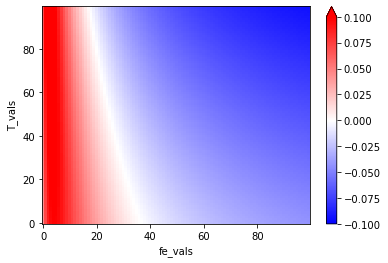

In [56]:
(sp_growthrate_5PAR - diat_growthrate_5PAR).plot(vmin=-0.1,vmax=0.1,cmap='bwr')

### 10 W/m2 PAR

In [58]:
### Specify parameters
Tref = 30.
q10 = 2.0

alpha_pi_diat = 0.3
alpha_pi_sp = 0.34

thetaN_max_diat = 4
thetaN_max_sp = 2.5

NtoC = 0.137

thetaC_diat = thetaN_max_diat * NtoC
thetaC_sp = thetaN_max_sp * NtoC

PCref_diat = 4.8
PCref_sp = 4.8

kFe_diat = 8.e-5
kFe_sp = 3.e-5

## PAR and Fe ranges and temperature
Fe_vals = np.arange(0.000004,0.00040,0.000004)
Temp_vals = np.arange(0,8,0.08)

PAR = 10



## initialize empty matrices
sp_growthrate_10PAR = np.full((100,100),np.nan)
diat_growthrate_10PAR = np.full((100,100),np.nan)

i=0
j=0

for Fe in Fe_vals: # i loop
    
    for T in Temp_vals: # j loop
        
        #calculate tfunc
        Tfunc = q10**((T - Tref) / 10.)
        
        ### temperature adjusted max growth rate
        max_gr = PCref_sp * Tfunc 
        
        ##### small phytoplankton
        sp_nut_lim = Fe/(Fe + kFe_sp)
        
        sp_light_lim = 1 - math.e ** ((-1. * alpha_pi_sp * thetaC_sp * PAR) / (max_gr * sp_nut_lim))
        
        sp_growthrate_10PAR[j,i] = max_gr * sp_nut_lim * sp_light_lim
        
        #### diatoms
        diat_nut_lim = Fe/(Fe + kFe_diat)
        diat_light_lim = 1 - math.e ** ((-1. * alpha_pi_diat * thetaC_diat * PAR) / (max_gr * diat_nut_lim))
        
        diat_growthrate_10PAR[j,i] = max_gr * diat_nut_lim * diat_light_lim
        
        j = j + 1
        
    i = i + 1
    j = 0
    
sp_growthrate_10PAR = xr.DataArray(sp_growthrate_10PAR,dims=('T_vals','fe_vals'))
diat_growthrate_10PAR = xr.DataArray(diat_growthrate_10PAR,dims=('T_vals','fe_vals'))

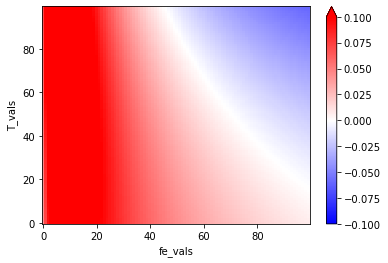

In [59]:
(sp_growthrate_10PAR - diat_growthrate_10PAR).plot(vmin=-0.1,vmax=0.1,cmap='bwr')

### 20 W/m2 PAR

In [60]:
### Specify parameters
Tref = 30.
q10 = 2.0

alpha_pi_diat = 0.3
alpha_pi_sp = 0.34

thetaN_max_diat = 4
thetaN_max_sp = 2.5

NtoC = 0.137

thetaC_diat = thetaN_max_diat * NtoC
thetaC_sp = thetaN_max_sp * NtoC

PCref_diat = 4.8
PCref_sp = 4.8

kFe_diat = 8.e-5
kFe_sp = 3.e-5

## PAR and Fe ranges and temperature
Fe_vals = np.arange(0.000004,0.00040,0.000004)
Temp_vals = np.arange(0,8,0.08)

PAR = 20



## initialize empty matrices
sp_growthrate_20PAR = np.full((100,100),np.nan)
diat_growthrate_20PAR = np.full((100,100),np.nan)

i=0
j=0

for Fe in Fe_vals: # i loop
    
    for T in Temp_vals: # j loop
        
        #calculate tfunc
        Tfunc = q10**((T - Tref) / 10.)
        
        ### temperature adjusted max growth rate
        max_gr = PCref_sp * Tfunc 
        
        ##### small phytoplankton
        sp_nut_lim = Fe/(Fe + kFe_sp)
        
        sp_light_lim = 1 - math.e ** ((-1. * alpha_pi_sp * thetaC_sp * PAR) / (max_gr * sp_nut_lim))
        
        sp_growthrate_20PAR[j,i] = max_gr * sp_nut_lim * sp_light_lim
        
        #### diatoms
        diat_nut_lim = Fe/(Fe + kFe_diat)
        diat_light_lim = 1 - math.e ** ((-1. * alpha_pi_diat * thetaC_diat * PAR) / (max_gr * diat_nut_lim))
        
        diat_growthrate_20PAR[j,i] = max_gr * diat_nut_lim * diat_light_lim
        
        j = j + 1
        
    i = i + 1
    j = 0
    
sp_growthrate_20PAR = xr.DataArray(sp_growthrate_20PAR,dims=('T_vals','fe_vals'))
diat_growthrate_20PAR = xr.DataArray(diat_growthrate_20PAR,dims=('T_vals','fe_vals'))

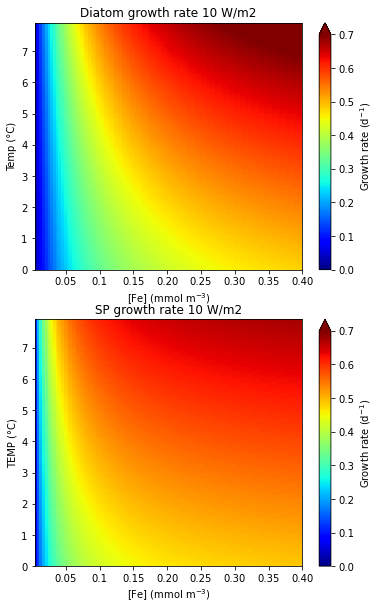

In [66]:
fig = plt.figure(figsize=(6,10))

ax = fig.add_subplot(2,1,1)
ax.set_title('Diatom growth rate 10 W/m2')
pc=ax.pcolormesh(Fe_vals, Temp_vals, diat_growthrate_10PAR,cmap='jet',vmin=0,vmax=0.7)
ax.set_ylabel('Temp (°C)')
ax.set_xlabel('[Fe] (mmol m$^{-3}$)')
labels = ['0.0','0.05','0.1','0.15','0.20','0.25','0.30','0.35','0.40']
ax.set_xticklabels(labels)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Growth rate (d$^{-1}$)')

ax = fig.add_subplot(2,1,2)
ax.set_title('SP growth rate 10 W/m2')
pc=ax.pcolormesh(Fe_vals, Temp_vals, sp_growthrate_10PAR,cmap='jet',vmin=0,vmax=0.7)
ax.set_ylabel('TEMP (°C)')
ax.set_xlabel('[Fe] (mmol m$^{-3}$)')
labels = ['0.0','0.05','0.1','0.15','0.20','0.25','0.30','0.35','0.40']
ax.set_xticklabels(labels)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Growth rate (d$^{-1}$)')



#fig.savefig('/glade/work/kristenk/figs/diatom_growth_rate.png', bbox_inches='tight', dpi=300, format='png');

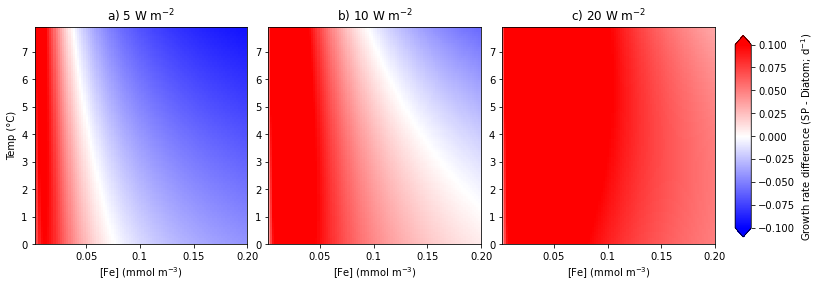

In [69]:
fig = plt.figure(figsize=(14,4))

## 5 PAR
ax = fig.add_subplot(1,3,1)
ax.set_title('a) 5 W m$^{-2}$')
pc=ax.pcolormesh(Fe_vals, Temp_vals, sp_growthrate_5PAR-diat_growthrate_5PAR,cmap='bwr',vmin=-0.1,vmax=0.1)
ax.set_ylabel('Temp (°C)')
ax.set_xlabel('[Fe] (mmol m$^{-3}$)')
labels = ['0.0','0.05','0.1','0.15','0.20','0.25','0.30','0.35','0.40']
ax.set_xticklabels(labels)

### 10 PAR
ax = fig.add_subplot(1,3,2)
ax.set_title('b) 10 W m$^{-2}$')
pc=ax.pcolormesh(Fe_vals, Temp_vals, sp_growthrate_10PAR-diat_growthrate_10PAR,cmap='bwr',vmin=-0.1,vmax=0.1)
#ax.set_ylabel('PAR (W m$^{-2}$)')
ax.set_xlabel('[Fe] (mmol m$^{-3}$)')
labels = ['0.0','0.05','0.1','0.15','0.20','0.25','0.30','0.35','0.40']
ax.set_xticklabels(labels)


### 20 PAR
ax = fig.add_subplot(1,3,3)
ax.set_title('c) 20 W m$^{-2}$')
pc=ax.pcolormesh(Fe_vals, Temp_vals, sp_growthrate_20PAR-diat_growthrate_20PAR,cmap='bwr',vmin=-0.1,vmax=0.1)
#ax.set_ylabel('PAR (W m$^{-2}$)')
ax.set_xlabel('[Fe] (mmol m$^{-3}$)')
labels = ['0.0','0.05','0.1','0.15','0.20','0.25','0.30','0.35','0.40']
ax.set_xticklabels(labels)

### color base
fig.subplots_adjust(right=0.8,wspace=0.1)
cbar_ax = fig.add_axes([0.82, 0.15, 0.016, 0.7])
fig.colorbar(pc, cax=cbar_ax, extend='both', label='Growth rate difference (SP - Diatom; d$^{-1}$)');

#fig.savefig('/glade/work/kristenk/figs/Fe_PAR_resource_competition.png', bbox_inches='tight', dpi=300, format='png');

### SIZ 1920s PAR 

In [47]:
### Specify parameters
Tref = 30.
q10 = 2.0

alpha_pi_diat = 0.3
alpha_pi_sp = 0.34

thetaN_max_diat = 4
thetaN_max_sp = 2.5

NtoC = 0.137

thetaC_diat = thetaN_max_diat * NtoC
thetaC_sp = thetaN_max_sp * NtoC

PCref_diat = 4.8
PCref_sp = 4.8

kFe_diat = 8.e-5
kFe_sp = 3.e-5

## PAR and Fe ranges and temperature
Fe_vals = np.arange(0.000004,0.00040,0.000004)
Temp_vals = np.arange(0,8,0.08)

PAR = PAR_1920s_SIZ



## initialize empty matrices
sp_growthrate_PAR_1920s_SIZ = np.full((100,100),np.nan)
diat_growthrate_PAR_1920s_SIZ = np.full((100,100),np.nan)

i=0
j=0

for Fe in Fe_vals: # i loop
    
    for T in Temp_vals: # j loop
        
        #calculate tfunc
        Tfunc = q10**((T - Tref) / 10.)
        
        ### temperature adjusted max growth rate
        max_gr = PCref_sp * Tfunc 
        
        ##### small phytoplankton
        sp_nut_lim = Fe/(Fe + kFe_sp)
        
        sp_light_lim = 1 - math.e ** ((-1. * alpha_pi_sp * thetaC_sp * PAR) / (max_gr * sp_nut_lim))
        
        sp_growthrate_PAR_1920s_SIZ[j,i] = max_gr * sp_nut_lim * sp_light_lim
        
        #### diatoms
        diat_nut_lim = Fe/(Fe + kFe_diat)
        diat_light_lim = 1 - math.e ** ((-1. * alpha_pi_diat * thetaC_diat * PAR) / (max_gr * diat_nut_lim))
        
        diat_growthrate_PAR_1920s_SIZ[j,i] = max_gr * diat_nut_lim * diat_light_lim
        
        j = j + 1
        
    i = i + 1
    j = 0
    
sp_growthrate_PAR_1920s_SIZ = xr.DataArray(sp_growthrate_PAR_1920s_SIZ,dims=('T_vals','fe_vals'))
diat_growthrate_PAR_1920s_SIZ = xr.DataArray(diat_growthrate_PAR_1920s_SIZ,dims=('T_vals','fe_vals'))

### 

In [ ]:
### Specify parameters
Tref = 30.
q10 = 2.0

alpha_pi_diat = 0.3
alpha_pi_sp = 0.34

thetaN_max_diat = 4
thetaN_max_sp = 2.5

NtoC = 0.137

thetaC_diat = thetaN_max_diat * NtoC
thetaC_sp = thetaN_max_sp * NtoC

PCref_diat = 4.8
PCref_sp = 4.8

kFe_diat = 8.e-5
kFe_sp = 3.e-5

## PAR and Fe ranges and temperature
Fe_vals = np.arange(0.000004,0.00040,0.000004)
Temp_vals = np.arange(0,8,0.08)

PAR = PAR_1920s_SIZ



## initialize empty matrices
sp_growthrate_5PAR = np.full((100,100),np.nan)
diat_growthrate_5PAR = np.full((100,100),np.nan)

i=0
j=0

for Fe in Fe_vals: # i loop
    
    for T in Temp_vals: # j loop
        
        #calculate tfunc
        Tfunc = q10**((T - Tref) / 10.)
        
        ### temperature adjusted max growth rate
        max_gr = PCref_sp * Tfunc 
        
        ##### small phytoplankton
        sp_nut_lim = Fe/(Fe + kFe_sp)
        
        sp_light_lim = 1 - math.e ** ((-1. * alpha_pi_sp * thetaC_sp * PAR) / (max_gr * sp_nut_lim))
        
        sp_growthrate_5PAR[j,i] = max_gr * sp_nut_lim * sp_light_lim
        
        #### diatoms
        diat_nut_lim = Fe/(Fe + kFe_diat)
        diat_light_lim = 1 - math.e ** ((-1. * alpha_pi_diat * thetaC_diat * PAR) / (max_gr * diat_nut_lim))
        
        diat_growthrate_5PAR[j,i] = max_gr * diat_nut_lim * diat_light_lim
        
        j = j + 1
        
    i = i + 1
    j = 0
    
sp_growthrate_5PAR = xr.DataArray(sp_growthrate_5PAR,dims=('T_vals','fe_vals'))
diat_growthrate_5PAR = xr.DataArray(diat_growthrate_5PAR,dims=('T_vals','fe_vals'))

### put plots together with 2090s temperature

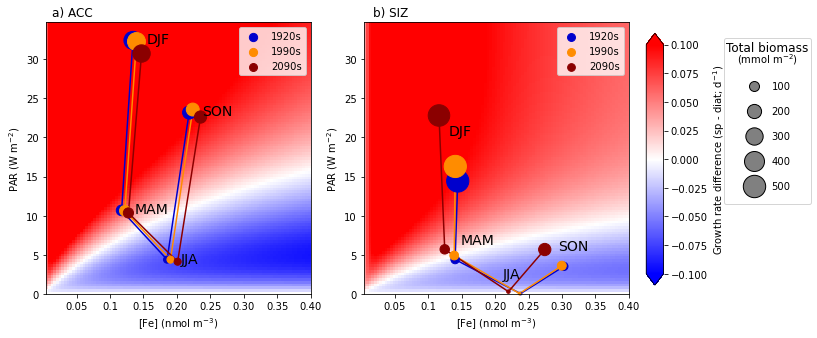

In [63]:
fig = plt.figure(figsize=(12,5))


######################################################### ACC
ax = fig.add_subplot(1,2,1)

ax.set_title('a) ACC',x=0.1,y=1)
pc=ax.pcolormesh(Fe_vals, PAR_vals, sp_growthrate_ACC_2090s-diat_growthrate_ACC_2090s,cmap='bwr',vmin=-0.1,vmax=0.1)
ax.set_ylabel('PAR (W m$^{-2}$)')
ax.set_xlabel('[Fe] (nmol m$^{-3}$)')

#1920s
s = [ACC_values_ds_1920s.phytoC_50m_zint.values*2]
ax.scatter(ACC_values_ds_1920s.Fe_avg_50m.values,ACC_values_ds_1920s.PAR_avg_50m.values,
        marker='o',s=s,color='mediumblue',label='1920s', zorder=2)
ax.plot(ACC_values_ds_1920s.Fe_avg_50m.values,ACC_values_ds_1920s.PAR_avg_50m.values,
        color='mediumblue',zorder=1)
# #1990s
s = [ACC_values_ds_1990s.phytoC_50m_zint.values*2]
ax.scatter(ACC_values_ds_1990s.Fe_avg_50m.values,ACC_values_ds_1990s.PAR_avg_50m.values,
        marker='o',s=s,color='darkorange',label='1990s', zorder=2)
ax.plot(ACC_values_ds_1990s.Fe_avg_50m.values,ACC_values_ds_1990s.PAR_avg_50m.values,
        color='darkorange',zorder=1)

# #2090s
s = [ACC_values_ds_2090s.phytoC_50m_zint.values*2]
ax.scatter(ACC_values_ds_2090s.Fe_avg_50m.values,ACC_values_ds_2090s.PAR_avg_50m.values,
        marker='o',s=s,color='darkred',label='2090s',zorder=2)
ax.plot(ACC_values_ds_2090s.Fe_avg_50m.values,ACC_values_ds_2090s.PAR_avg_50m.values,
        color='darkred',zorder=1)

## add season labels
annotations = ds.season.values
for i, label in enumerate(annotations):
    plt.annotate(label, (ACC_values_ds_1920s.Fe_avg_50m.values[i]+0.00002, ACC_values_ds_1920s.PAR_avg_50m.values[i]-0.4),fontsize=14)

ax.legend(markerscale=0.6,scatterpoints=1, fontsize=10)
### add x axis labels in nmol/m3
labels = ['0.0','0.05','0.1','0.15','0.20','0.25','0.30','0.35','0.40']
ax.set_xticklabels(labels)

######################################################### SIZ

ax = fig.add_subplot(1,2,2)

ax.set_title('b) SIZ', x=0.1,y=1)
pc=ax.pcolormesh(Fe_vals, PAR_vals, sp_growthrate_SIZ_2090s-diat_growthrate_SIZ_2090s,cmap='bwr',vmin=-0.1,vmax=0.1)
ax.set_ylabel('PAR (W m$^{-2}$)')
ax.set_xlabel('[Fe] (nmol m$^{-3}$)')

#1920s
s = [SIZ_values_ds_1920s.phytoC_50m_zint.values*2]
ax.scatter(SIZ_values_ds_1920s.Fe_avg_50m.values,SIZ_values_ds_1920s.PAR_avg_50m.values,
        marker='o',s=s,color='mediumblue',label='1920s',clip_on=False,zorder=2)
ax.plot(SIZ_values_ds_1920s.Fe_avg_50m.values,SIZ_values_ds_1920s.PAR_avg_50m.values,
        color='mediumblue',zorder=1)
# #1990s
s = [SIZ_values_ds_1990s.phytoC_50m_zint.values*2]
ax.scatter(SIZ_values_ds_1990s.Fe_avg_50m.values,SIZ_values_ds_1990s.PAR_avg_50m.values,
        marker='o',s=s,color='darkorange',label='1990s',clip_on=False,zorder=2)
ax.plot(SIZ_values_ds_1990s.Fe_avg_50m.values,SIZ_values_ds_1990s.PAR_avg_50m.values,
        color='darkorange',zorder=1)
# #1990s
s = [SIZ_values_ds_2090s.phytoC_50m_zint.values*2]
ax.scatter(SIZ_values_ds_2090s.Fe_avg_50m.values,SIZ_values_ds_2090s.PAR_avg_50m.values,
        marker='o',s=s,color='darkred',label='2090s',clip_on=False,zorder=2)
ax.plot(SIZ_values_ds_2090s.Fe_avg_50m.values,SIZ_values_ds_2090s.PAR_avg_50m.values,
        color='darkred',zorder=1)

## add season labels
annotations = ds.season.values
# for i, label in enumerate(annotations):
#     plt.annotate(label, (SIZ_values_ds_1990s.Fe_avg_50m.values[i]+0.00001, SIZ_values_ds_1990s.PAR_avg_50m.values[i]+0.4), fontsize=14)

plt.annotate(annotations[0], (SIZ_values_ds_1990s.Fe_avg_50m.values[0]-0.00001, SIZ_values_ds_1990s.PAR_avg_50m.values[0]+4), fontsize=14)
plt.annotate(annotations[1], (SIZ_values_ds_1990s.Fe_avg_50m.values[1]+0.00001, SIZ_values_ds_1990s.PAR_avg_50m.values[1]+1.5), fontsize=14)
plt.annotate(annotations[2], (SIZ_values_ds_1990s.Fe_avg_50m.values[2]-0.000025, SIZ_values_ds_1990s.PAR_avg_50m.values[2]+2), fontsize=14)
plt.annotate(annotations[3], (SIZ_values_ds_1990s.Fe_avg_50m.values[3]-0.000005, SIZ_values_ds_1990s.PAR_avg_50m.values[3]+2), fontsize=14)

ax.legend(markerscale=0.5,scatterpoints=1, fontsize=10)

labels = ['0.0','0.05','0.1','0.15','0.20','0.25','0.30','0.35','0.40']
ax.set_xticklabels(labels)

#plt.annotate('Total biomass', (0.0005, 3), fontsize=14)
plt.figtext(0.912, 0.8, 'Total biomass', fontsize=12)

### color base
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax, extend='both', label='Growth rate difference (sp - diat; d$^{-1}$)');

for x in [100, 200, 300, 400, 500]:
    plt.scatter([], [], c='gray', alpha=1, s=x, label=str(x), marker='o',edgecolors='black')
# legend2 = ax.legend(loc='upper center', bbox_to_anchor=(0.8, 0.8), ncol=1, fancybox=True, shadow=False, title='Biomass')

legend2 = plt.legend(loc="upper right", title="(mmol m$^{-2}$)", bbox_to_anchor=(9.8, 1),
                     fancybox=True, labelspacing=1.5, borderpad=1.3)

#fig.savefig('/glade/work/kristenk/figs/Fe_PAR_resource_competition.png', bbox_inches='tight', dpi=300, format='png');

### Put plots together with 1920s temp

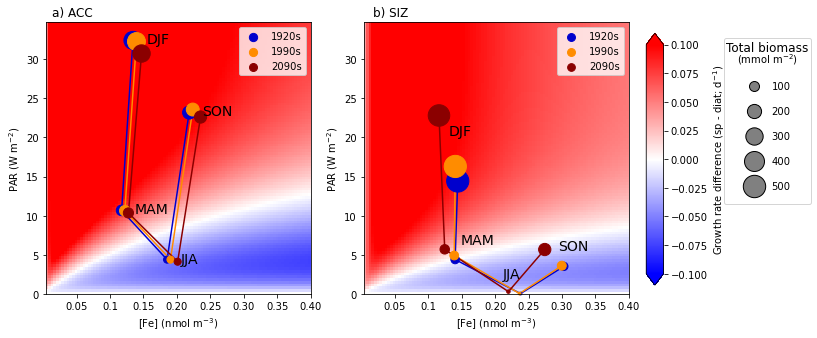

In [64]:
fig = plt.figure(figsize=(12,5))


######################################################### ACC
ax = fig.add_subplot(1,2,1)

ax.set_title('a) ACC',x=0.1,y=1)
pc=ax.pcolormesh(Fe_vals, PAR_vals, sp_growthrate_ACC_1920s-diat_growthrate_ACC_1920s,cmap='bwr',vmin=-0.1,vmax=0.1)
ax.set_ylabel('PAR (W m$^{-2}$)')
ax.set_xlabel('[Fe] (nmol m$^{-3}$)')

#1920s
s = [ACC_values_ds_1920s.phytoC_50m_zint.values*2]
ax.scatter(ACC_values_ds_1920s.Fe_avg_50m.values,ACC_values_ds_1920s.PAR_avg_50m.values,
        marker='o',s=s,color='mediumblue',label='1920s', zorder=2)
ax.plot(ACC_values_ds_1920s.Fe_avg_50m.values,ACC_values_ds_1920s.PAR_avg_50m.values,
        color='mediumblue',zorder=1)
# #1990s
s = [ACC_values_ds_1990s.phytoC_50m_zint.values*2]
ax.scatter(ACC_values_ds_1990s.Fe_avg_50m.values,ACC_values_ds_1990s.PAR_avg_50m.values,
        marker='o',s=s,color='darkorange',label='1990s', zorder=2)
ax.plot(ACC_values_ds_1990s.Fe_avg_50m.values,ACC_values_ds_1990s.PAR_avg_50m.values,
        color='darkorange',zorder=1)

# #2090s
s = [ACC_values_ds_2090s.phytoC_50m_zint.values*2]
ax.scatter(ACC_values_ds_2090s.Fe_avg_50m.values,ACC_values_ds_2090s.PAR_avg_50m.values,
        marker='o',s=s,color='darkred',label='2090s',zorder=2)
ax.plot(ACC_values_ds_2090s.Fe_avg_50m.values,ACC_values_ds_2090s.PAR_avg_50m.values,
        color='darkred',zorder=1)

## add season labels
annotations = ds.season.values
for i, label in enumerate(annotations):
    plt.annotate(label, (ACC_values_ds_1920s.Fe_avg_50m.values[i]+0.00002, ACC_values_ds_1920s.PAR_avg_50m.values[i]-0.4),fontsize=14)

ax.legend(markerscale=0.6,scatterpoints=1, fontsize=10)
### add x axis labels in nmol/m3
labels = ['0.0','0.05','0.1','0.15','0.20','0.25','0.30','0.35','0.40']
ax.set_xticklabels(labels)

######################################################### SIZ

ax = fig.add_subplot(1,2,2)

ax.set_title('b) SIZ', x=0.1,y=1)
pc=ax.pcolormesh(Fe_vals, PAR_vals, sp_growthrate_SIZ_1920s-diat_growthrate_SIZ_1920s,cmap='bwr',vmin=-0.1,vmax=0.1)
ax.set_ylabel('PAR (W m$^{-2}$)')
ax.set_xlabel('[Fe] (nmol m$^{-3}$)')

#1920s
s = [SIZ_values_ds_1920s.phytoC_50m_zint.values*2]
ax.scatter(SIZ_values_ds_1920s.Fe_avg_50m.values,SIZ_values_ds_1920s.PAR_avg_50m.values,
        marker='o',s=s,color='mediumblue',label='1920s',clip_on=False,zorder=2)
ax.plot(SIZ_values_ds_1920s.Fe_avg_50m.values,SIZ_values_ds_1920s.PAR_avg_50m.values,
        color='mediumblue',zorder=1)
# #1990s
s = [SIZ_values_ds_1990s.phytoC_50m_zint.values*2]
ax.scatter(SIZ_values_ds_1990s.Fe_avg_50m.values,SIZ_values_ds_1990s.PAR_avg_50m.values,
        marker='o',s=s,color='darkorange',label='1990s',clip_on=False,zorder=2)
ax.plot(SIZ_values_ds_1990s.Fe_avg_50m.values,SIZ_values_ds_1990s.PAR_avg_50m.values,
        color='darkorange',zorder=1)
# #1990s
s = [SIZ_values_ds_2090s.phytoC_50m_zint.values*2]
ax.scatter(SIZ_values_ds_2090s.Fe_avg_50m.values,SIZ_values_ds_2090s.PAR_avg_50m.values,
        marker='o',s=s,color='darkred',label='2090s',clip_on=False,zorder=2)
ax.plot(SIZ_values_ds_2090s.Fe_avg_50m.values,SIZ_values_ds_2090s.PAR_avg_50m.values,
        color='darkred',zorder=1)

## add season labels
annotations = ds.season.values
# for i, label in enumerate(annotations):
#     plt.annotate(label, (SIZ_values_ds_1990s.Fe_avg_50m.values[i]+0.00001, SIZ_values_ds_1990s.PAR_avg_50m.values[i]+0.4), fontsize=14)

plt.annotate(annotations[0], (SIZ_values_ds_1990s.Fe_avg_50m.values[0]-0.00001, SIZ_values_ds_1990s.PAR_avg_50m.values[0]+4), fontsize=14)
plt.annotate(annotations[1], (SIZ_values_ds_1990s.Fe_avg_50m.values[1]+0.00001, SIZ_values_ds_1990s.PAR_avg_50m.values[1]+1.5), fontsize=14)
plt.annotate(annotations[2], (SIZ_values_ds_1990s.Fe_avg_50m.values[2]-0.000025, SIZ_values_ds_1990s.PAR_avg_50m.values[2]+2), fontsize=14)
plt.annotate(annotations[3], (SIZ_values_ds_1990s.Fe_avg_50m.values[3]-0.000005, SIZ_values_ds_1990s.PAR_avg_50m.values[3]+2), fontsize=14)

ax.legend(markerscale=0.5,scatterpoints=1, fontsize=10)

labels = ['0.0','0.05','0.1','0.15','0.20','0.25','0.30','0.35','0.40']
ax.set_xticklabels(labels)

#plt.annotate('Total biomass', (0.0005, 3), fontsize=14)
plt.figtext(0.912, 0.8, 'Total biomass', fontsize=12)

### color base
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax, extend='both', label='Growth rate difference (sp - diat; d$^{-1}$)');

for x in [100, 200, 300, 400, 500]:
    plt.scatter([], [], c='gray', alpha=1, s=x, label=str(x), marker='o',edgecolors='black')
# legend2 = ax.legend(loc='upper center', bbox_to_anchor=(0.8, 0.8), ncol=1, fancybox=True, shadow=False, title='Biomass')

legend2 = plt.legend(loc="upper right", title="(mmol m$^{-2}$)", bbox_to_anchor=(9.8, 1),
                     fancybox=True, labelspacing=1.5, borderpad=1.3)
#fig.savefig('/glade/work/kristenk/figs/Fe_PAR_resource_competition.png', bbox_inches='tight', dpi=300, format='png');